# Applying Naive Bayes to building a Spam Filter
The goal of this project is to use to use the Naive Bayes algorithm to build a spam filter for SMS messages. I want to build a spam filter that will have an accuracy greater than 75%. This will allow us to specify whether or not a message was correctly specified as spam or non-spam aliased as "ham".

In order to train this algorithm I'll be using a dataset of 5,572 SMS messages that have been classified already. This dataset was put together by Tiago Almeida and Joe Maria Gomez Hidalgo. It can be found at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) along with other datasets used to learn the fundamentals of Machine Learning. 

In [1]:
# Load necessary packages
import pandas as pd 
sms_spam = pd.read_csv('/Users/drewsdesktop/Desktop/Data Science/Datasets/SMSSpamCollection', sep= '\t', header = None, names = ['Label', 'SMS'])

# Hide deprecation warnings
import warnings
warnings.filterwarnings("ignore")

# Check the shape of the dataframe
print(sms_spam.shape)

# View the first 5 rows of the dataframe
sms_spam.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Looking at the dataset above, we can see that there are already labels for each SMS message. I want to have a look at the distribution of the labels. To do this, I'm going to use the `Series.value_counts` method. 

In [2]:
# Count the number of values for each unique label (only 2)
sms_spam['Label'].value_counts(normalize= True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

It looks like 86.5% of the messages are labeled as `ham` and 13% of the labels are labeled as `spam`. So to summarize, we know the folowing:
- The dataset has 5,572 rows and 2 columns. 
- The names of the columns are `Label` and `SMS`. 
- The 86.5% of messages are labeled as ham. 
- 13% of messages are labeld as spam. 

## Splitting the set up into training and testing sets

In order to gauge how well our spam filter works we will have to split up our dataset into a training set and a testing set. For this project our split will be:
- 80% training or 4,458 messages.
- 20% testing or 1,114 messages.

First, we'll start by randomizing the entire dataset so that the messages won't be clumped together by what they are classified as. 

In [3]:
# Randomize the dataset 
randomized_data = sms_spam.sample(frac=1, random_state = 1)

# Calculate the index for the splitting of the set 
training_test_index = round(len(randomized_data) * .8)

# Split into sets 
training_set = randomized_data[:training_test_index].reset_index(drop = True)
test_set = randomized_data[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


Next, I'll have a look at the distribution of messages in the new set. I want similar levels of ham messages and spam messages for each dataset when compared to the base dataset they came from. 

In [4]:
# Training set evaluation 
training_set['Label'].value_counts(normalize = True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

Looks good for the training set. Next, I'll have a look at the testing set. 

In [5]:
# Testing set evaluation 
test_set['Label'].value_counts(normalize = True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64

The testing set also has similar percentages to that of the base dataset I pulled into the jupyter environment. 

## Data Cleaning
We need to be able to perform the calculations necessary for the probability values needed for the Naive Bayes algorithm. In order to calculate these probabilities we will have to restructure our data into a format that will have the label still, but each column will represent one of the words in our vocabulary that will be used to filter for spam. 

First, what we'll do in our data cleaning process is to remove all punctuation from the sms column. We can do this using regex. The regex expression `\W` will detect any character that isn't from a-z, A-Z, 0-9. Let's start with the trainng set. 

In [6]:
# Cleaning the training set for punctuation
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head()


,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


**Key note**: For the cell above there was a deprecation warning for the replace method which states that the default value for that method will change in future versions. 

It looks like we were able to remove characters that we didn't want and also removed the punctuation. Next, what we will do is creat the vocabulary for by which we will filter with. This is all of the unique words in our set. 

In [7]:
# Creating vocabulary 
## Transform each message into a list, split the string on the space character
training_set['SMS'] = training_set['SMS'].str.split(' ')

# Initialize an empty list named vocabulary
vocabulary = []

# Loop through the SMS column
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
        
vocabulary = list(set(vocabulary))

In [8]:
#Check the length of the vocabulary list 
len(vocabulary)

7784

## Finalizing the training set 
Next, using the vocabulary that we just generated we are going yo transform the dataset into a new dataframe using the words we gathered. 

In [9]:
# Initialize a dictionary
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

# Loop over the sms messages to create columns for each word in the message

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [10]:
# Create new dataframe 
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,,handsomes,se,edwards,logo,dat,menu,throw,0870,pouch,...,bb,loads,87070,barkleys,morrow,her,tonite,muz,69855,ag
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Combine the word count dataframe with the original dataframe
training_set_clean = pd.concat([training_set, word_counts], axis = 1)
training_set_clean.head()

,Label,SMS,,handsomes,se,edwards,logo,dat,menu,throw,...,bb,loads,87070,barkleys,morrow,her,tonite,muz,69855,ag
0,ham,"[yep, , by, the, pretty, sculpture]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, , princess, , are, you, going, to, make,...",3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,"[havent, ]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, , , there, s...",7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Filtering messages

Now that we've finished cleaning the training set, next we'll start working on the spam filter itself. Before we start, it's important to understand what we are looking for first. Essentially, what we want to know as depicted below is:
- The probability a message is spam based on the words in the message. 
- The probability a message is ham based on the words that make up the message. 

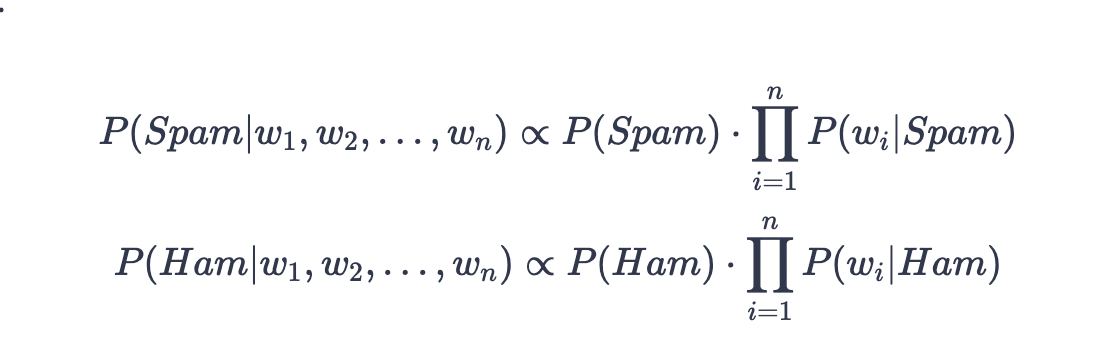


In order to calculate the information we'll need to use the following equations as well. 

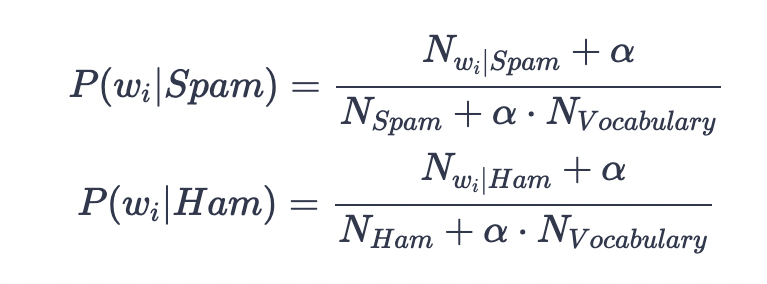

Some of the terms in the equations above will include the same value for every new message, so the first we thing we will calculate are the probability of spam and the probability of ham. 

In [12]:
# Isolating message by spam and ham initially 
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

spam_messages.head()

,Label,SMS,,handsomes,se,edwards,logo,dat,menu,throw,...,bb,loads,87070,barkleys,morrow,her,tonite,muz,69855,ag
16,spam,"[freemsg, why, haven, t, you, replied, to, my,...",5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,spam,"[congrats, , 2, mobile, 3g, videophones, r, yo...",10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56,spam,"[free, message, activate, your, 500, free, tex...",3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,spam,"[call, from, 08702490080, , , tells, u, 2, cal...",10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,spam,"[someone, has, conacted, our, dating, service,...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It looks like it worked, next we need to calculate the probabilities of spam and ham. 

An important thing to remember are some of the other variables that we will need to calculate. These are:
- n_spam = the number of words in all spam messages. 
- n_ham = the number of words in all ham messages. 

Let's calculate these below as well. 

In [13]:
# Calculate the probablity of spam and ham 
p_spam = len(spam_messages) / len(training_set_clean)
p_ham = len(ham_messages) / len(training_set_clean)

print('The probability of a message being spam is: ', p_spam)
print('The probability of a message being ham is: ', p_ham)

The probability of a message being spam is:  0.13458950201884254
The probability of a message being ham is:  0.8654104979811574


In [14]:
# Calculate the number of words in all spam and ham messages

# N spam 
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

print('The number of words in all spam messages: ', n_spam)

# N ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()
print('The number of words in all ham messages is: ', n_ham)

The number of words in all spam messages:  17956
The number of words in all ham messages is:  71219


In [15]:
# Calculate the number of words in the vocabulary 
n_vocabulary = len(vocabulary)
print('The number of words in the vocabulary is: ', n_vocabulary)

The number of words in the vocabulary is:  7784


In [16]:
# Setting the alpha smoothing variable: Laplace
alpha = 1

We now have the terms needed to calculate the parameters needed for the algorithm. Each parameter will be a conditional probability value that is associated with the each word in the vocabulary. The parameter will be calculated with the formula below:

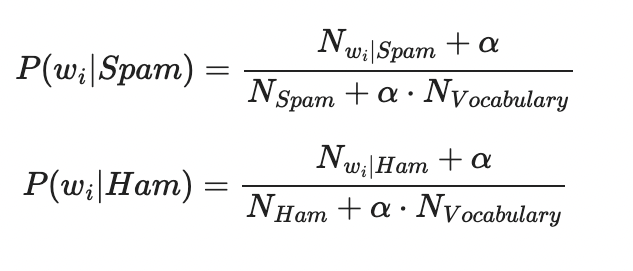



In [17]:
# Initiate the parameters
parameters_spam = {unique_word: 0 for unique_word in vocabulary}
parameters_ham = {unique_word: 0 for unique_word in vocabulary}


# Calculate the parameters 

for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha * n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum()
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha * n_vocabulary)
    parameters_ham[word] = p_word_given_ham

## Create the Spam filter 

We now have the constants and parameters needed to start working on our spam filter. The spam filter will be a function that does the following:
- Takes in a a message as the input. 
- Calculates the probability a message is spam given a message. 
- Calculate the probability a word is ham given a message. 
- Compares the two probabilities and IF:
    * p_ham_given_message > p_spam_given_nessage = 'ham'
    * p_ham_given_message < p_spam_given_message = 'spam'
    * p_ham_given_message = p_spam_given_message, THEN the algorithm will ask for human intervention. 
   
The skeleton of this function can be seen below:


In [18]:
# Spam filter function 
import re 

# Function 
def classify(message):
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
    
    # Calculate the probabilities for spam and ham given a message 
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
        
    else:
        print('Probabilities are equal, message requires a human to classify it')

So now we are going to test this function to see how it performs. 

In [19]:
classify('WINNER!! Here is your secret code to unlock your winning prize: d43333.')

P(Spam|message): 3.6744756165717854e-30
P(Ham|message): 1.1987615339241833e-35
Label: Spam


It looks like it was pretty succesful in labeling the messages. Next, I'll give it a go on more realistic message. 

In [20]:
classify('Sounds good bro. I will talk to you on Friday then.')

P(Spam|message): 7.734085816148341e-37
P(Ham|message): 3.692811609963599e-31
Label: Ham


It looks like the filter did see that this was a message meant for someone and not a spam message. 

## Testing the accuracy of the filter 
So far it looks like our filter is performing well. Next, what we want to do is to check how the filter performs against the testing set that I put aside earlier. 

First, I'll write a function that will return classification labels rather than printing them like we did before. 

In [21]:
# Updated classify function that will return labels instead of printing them 

def classify_test_set(message):
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
    
    p_spam_given_message = p_spam 
    p_ham_given_message = p_ham 
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    # Compare the probabilities 
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'
    

In [22]:
# Create a new column in the test set 
test_set['prediction'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,prediction
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


## Measuring the accuracy of the filter

It looks like we were able to create this new column using the function and the apply method. Next, we are going to measure the accuracy of the spam filter.

Accuracy can be measured as : number of correctly classified messages / total number of classified messages

In [23]:
# Initialize a variable named correct and the total variable 
correct = 0
total = test_set.shape[0]

In [24]:
# Iterate over the test set data frame 
for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['prediction']:
        correct += 1
        
print('Correct classifications: ', correct)
print('Incorrect classifications: ', total - correct)
print('Accuracy of the filter: ', correct / total)

Correct classifications:  1099
Incorrect classifications:  15
Accuracy of the filter:  0.9865350089766607


The accuracy of the spam filter was 98.6 % which I'd say is really good. It looked at 1,114 messages and classified 1099 of them correctly. Next, what I'll do is analyze the messages which were classified incorrectly and try to figure out some reasons why they may have been misclassified. 

## Analyzing misclassified messages

I'll start by filter the `test_set` dataframe for instances where the prediction and classification were not equal to each other. 

In [25]:
# Filter the dataframe for incorrect classifications 
incorrect_classifications = test_set[test_set['Label'] != test_set['prediction']]

# View the first 5 rows
incorrect_classifications.head(15)

,Label,SMS,prediction
114,spam,Not heard from U4 a while. Call me now am here...,ham
152,ham,Unlimited texts. Limited minutes.,spam
159,ham,26th OF JULY,spam
284,ham,Nokia phone is lovly..,spam
293,ham,A Boy loved a gal. He propsd bt she didnt mind...,needs human classification
302,ham,No calls..messages..missed calls,spam
319,ham,We have sent JD for Customer Service cum Accou...,spam
331,ham,Just taste fish curry :-P,spam
504,spam,Oh my god! I've found your number again! I'm s...,ham
546,spam,"Hi babe its Chloe, how r u? I was smashed on s...",ham


## Conclusions

It looks like some of the issues with the classification algorithm are:
- Classifying an ad from a phone carrier as spam. 
- The filter seems to struggle with misspelled words, all caps, and sentences with poor grammar.
- Another thing that I've noticed is that promotions were classified as spam the majority of the time.

**Next steps**:

Some recommendations to improve the algorithm are making it sensitive to letter case which seemed to be an issue from promotional messages.

Additionally, although the accuracy of the algorithm is quite high using alternative more advanced algorithms to classify the messages could be useful. The reasoning behind this is the underlying assumption from the Naive Bayes algorithm that all probabilities are independent. In the case of a language, this isn't really true. Sentence structure has patterns within it, so certain combinations of words are certainly likely to be more common than others. Just from doing some brief research some alternative algorithms for building spam filters are:

- Multilayer perceptron neural networks
- Radial base function neural networks

However, for the time being that is outside of the scope of this project. 